In [1]:
### Packages
from datetime import datetime
import time
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22
plt.rc('font', size=MEDIUM_SIZE)            # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)        # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)        # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)       # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)       # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)       # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)     # fontsize of the figure title

# Dataset
from keras.datasets import cifar10

# Subroutines
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
import keras_tuner as kt
from sklearn.metrics import confusion_matrix

# Additional configurations, @see config.py
import config

### Configurations
# Training-Size
num_train = config.num_train                   # 60000 for full data set 
num_test  = config.num_test                    # 10000 for full data set




In [2]:
# Simple functions to log information
path = os.getcwd()+"/log"
logDir = os.path.exists(path)
if not logDir:
    os.makedirs(path)

plots = os.getcwd()+"/plots"
logDir = os.path.exists(plots)
if not logDir:
    os.makedirs(plots)

training_results = path+"/keras-nn-training-log.txt"
def log_training_results(*s):
    with open(training_results, 'a') as f:
        for arg in s:
            print(arg, file=f)
            print(arg)

hyperparameter_search_log = path+"/keras-nn-hyperparameter-tuning-log.txt"
def log_hyperparameter_search(*s):
    with open(hyperparameter_search_log, 'a') as f:
        for arg in s:
            print(arg, file=f)
            print(arg)

print("Generated data will be located in ", training_results, hyperparameter_search_log)
print("Generated plots will be located in ", plots)

log_training_results("[%s] on (%s, %s) using (Train: %s, Test: %s)" % (datetime.now(), config.os, config.cpu, config.num_train, config.num_test))
if config.hyper_parameter_search:
    log_hyperparameter_search("[%s] on (%s, %s) using (Train: %s, Test: %s)" % (datetime.now(), config.os, config.cpu, config.num_train, config.num_test))



Generated data will be located in  c:\Users\auerth\Desktop\Study\CIFAR10_Benchmark\src/log/keras-nn-training-log.txt c:\Users\auerth\Desktop\Study\CIFAR10_Benchmark\src/log/keras-nn-hyperparameter-tuning-log.txt
Generated plots will be located in  c:\Users\auerth\Desktop\Study\CIFAR10_Benchmark\src/plots
[2022-09-15 12:51:42.440080] on (Windows-10-10.0.19044-SP0, Intel64 Family 6 Model 140 Stepping 1, GenuineIntel) using (Train: 25000, Test: 5000)
[2022-09-15 12:51:42.442026] on (Windows-10-10.0.19044-SP0, Intel64 Family 6 Model 140 Stepping 1, GenuineIntel) using (Train: 25000, Test: 5000)


In [3]:
# Fetch CIFAR10-Data from Keras repository
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [4]:
print("\t\t\t\t (Sets,  X,  Y, RGB)")
print("Shape of training data:\t\t", X_train.shape)
print("Shape of training labels:\t", y_train.shape)
print("Shape of testing data:\t\t", X_test.shape)
print("Shape of testing labels:\t", y_test.shape)

				 (Sets,  X,  Y, RGB)
Shape of training data:		 (50000, 32, 32, 3)
Shape of training labels:	 (50000, 1)
Shape of testing data:		 (10000, 32, 32, 3)
Shape of testing labels:	 (10000, 1)


C:\Users\auerth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


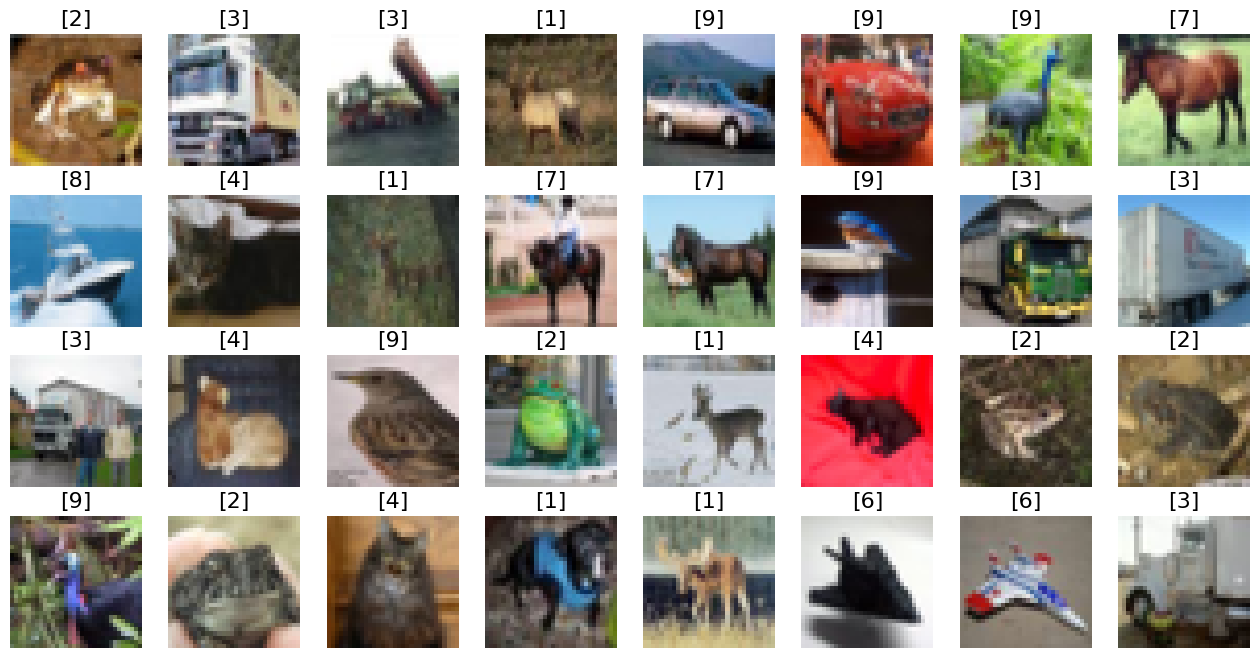

In [5]:
# Visualize some examples
cols=8
rows=4
fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(cols*2, rows*2))
index = 0
for i in range(rows):
    for j in range(cols):
        ax[i,j].imshow(X_train[index])
        ax[i,j].set_title(y_train[y_train[index][0]], fontsize=16)
        ax[i,j].imshow(X_train[index])
        ax[i,j].axis('off')
        index += 1
plt.show()
fig.savefig('plots/cifar10_examples.png')


In [6]:
train_data = X_train
train_label = y_train
test_data = X_test
test_label = y_test

In [7]:
# Reshape the data such that we have access to every pixel of the image
train_data = X_train.astype('float32')
train_label = y_train.astype("float32")
test_data = X_test.astype('float32')
test_label = y_test.astype("float32")


In [8]:
# We know the RGB color code where different values produce various colors. It is also difficult to remember every color combination. 
# We already know that each pixel has its unique color code and also we know that it has a maximum value of 255. 
# To perform Machine Learning, it is important to convert all the values from 0 to 255 for every pixel to a range of values from 0 to 1.
train_data = train_data / 255
test_data = test_data / 255

In [9]:
# Force the amount of columns to fit the necessary sizes required by the neural network
train_label = keras.utils.to_categorical(train_label, config.num_classes)
test_label = keras.utils.to_categorical(test_label, config.num_classes)

In [10]:
# As an optional step, we decrease the training and testing data size, such that the algorithms perform their execution in acceptable time
train_data = train_data[1:num_train,]
train_label = train_label[1:num_train]

test_data = test_data[1:num_test,]
test_label = test_label[1:num_test]

In [11]:
print("\t\t\t\t (Sets,  X, Y, RGB )")
print("Reshaped training data:\t\t", train_data.shape)
print("Reshaped training labels:\t", train_label.shape)
print("Reshaped testing data:\t\t", test_data.shape)
print("Reshaped testing labels:\t", test_label.shape)

				 (Sets,  X, Y, RGB )
Reshaped training data:		 (24999, 32, 32, 3)
Reshaped training labels:	 (24999, 10)
Reshaped testing data:		 (4999, 32, 32, 3)
Reshaped testing labels:	 (4999, 10)


In [12]:
# Create model: https://keras.io/guides/sequential_model/
model = Sequential()

# First convolutional layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32,32,3), activation='relu', padding='same')) 

# Second convolutional layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))

# Max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25)) 

# Flatten input into feature vector and feed into dense layer
model.add(Flatten()) 
model.add(Dense(units=config.num_of_units, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=config.num_of_units, activation='relu'))
model.add(Dropout(0.5))

# Outputs from dense layer are projected onto 10 unit output layer
model.add(Dense(units=config.num_classes, activation="softmax"))

# Compile model
optimizer = keras.optimizers.RMSprop(
    learning_rate=0.0001,
    epsilon = 1e-6,
)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 256)               1843456   
                                                        

In [13]:
# Train model
start_time = time.time()
history = model.fit(
    x=train_data, 
    y=train_label, 
    batch_size=config.batch_size, 
    epochs=config.num_epochs, 
    shuffle=True, 
    validation_data=(test_data, test_label))
end_time = time.time() - start_time

params = {"Keras":{"batch_size":config.batch_size, "epochs":config.num_epochs}}
log_training_results("Trained new model: %s in %s seconds" % (params, end_time))

Epoch 1/10
782/782 [==============================] - 49s 60ms/step - loss: 2.0410 - accuracy: 0.2435 - val_loss: 1.7223 - val_accuracy: 0.4011
Epoch 2/10
782/782 [==============================] - 49s 62ms/step - loss: 1.7233 - accuracy: 0.3689 - val_loss: 1.5077 - val_accuracy: 0.4605
Epoch 3/10
782/782 [==============================] - 45s 58ms/step - loss: 1.5667 - accuracy: 0.4237 - val_loss: 1.4187 - val_accuracy: 0.4879
Epoch 4/10
782/782 [==============================] - 44s 56ms/step - loss: 1.4636 - accuracy: 0.4648 - val_loss: 1.3564 - val_accuracy: 0.5219
Epoch 5/10
782/782 [==============================] - 44s 57ms/step - loss: 1.3893 - accuracy: 0.4973 - val_loss: 1.3088 - val_accuracy: 0.5407
Epoch 6/10
782/782 [==============================] - 49s 62ms/step - loss: 1.3165 - accuracy: 0.5264 - val_loss: 1.2366 - val_accuracy: 0.5563
Epoch 7/10
782/782 [==============================] - 48s 61ms/step - loss: 1.2673 - accuracy: 0.5491 - val_loss: 1.2091 - val_accuracy:

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
fig.savefig('plots/training_history_standard.png')

In [14]:
# Evaluate model based on supplied tags
start_time = time.time()
test_loss, test_acc = model.evaluate(train_data, train_label)
end_time = time.time() - start_time

log_training_results("\tPredicting train data -- execution time: %ss" % (end_time))
log_training_results("\t[%s] -- Accuracy: %s; Loss: %s" % (params, test_acc, test_loss))  

782/782 [==============================] - 8s 10ms/step - loss: 0.9405 - accuracy: 0.6679
	Predicting train data -- execution time: 8.170771598815918s
	[{'Keras': {}}] -- Accuracy: 0.6679067015647888; Loss: 0.9404692053794861


In [15]:
# Evaluate model based on supplied tags
start_time = time.time()
test_loss, test_acc = model.evaluate(test_data, test_label)
end_time = time.time() - start_time

log_training_results("\tPredicting test data --  execution time: %ss" % (end_time))
log_training_results("\t[%s] -- Accuracy: %s; Loss: %s" % (params, test_acc, test_loss))  

157/157 [==============================] - 2s 10ms/step - loss: 1.0805 - accuracy: 0.6127
	Predicting test data --  execution time: 1.6620118618011475s
	[{'Keras': {}}] -- Accuracy: 0.6127225160598755; Loss: 1.0805423259735107


In [16]:
# Let model predict data
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_label, axis=1)

157/157 [==============================] - 2s 10ms/step


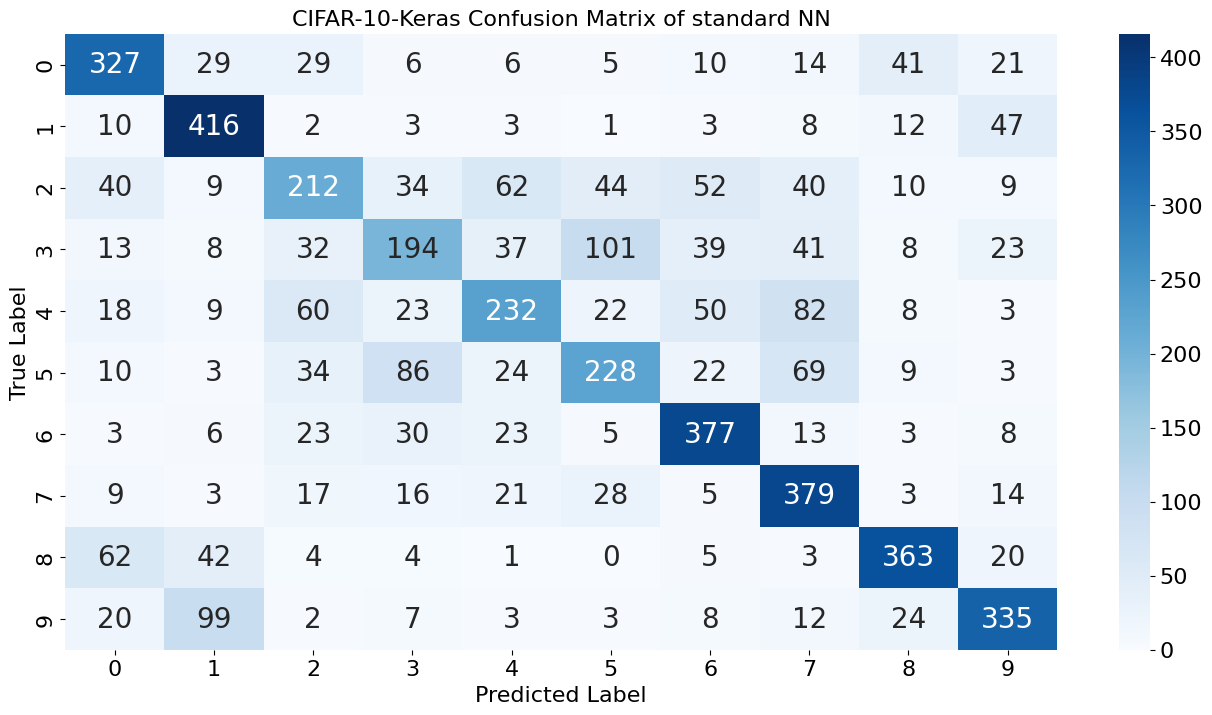

In [17]:
# Visualize estimation over correct and incorrect prediction via confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.heatmap(confusion_mtx, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('CIFAR-10-Keras Confusion Matrix of standard NN')
plt.show()
fig.savefig('plots/ConfusionMatrix_standard.png')

In [18]:
if not config.hyper_parameter_search:
    print("Terminating without hyperparameter search.")
    exit(0)
print("Starting hyperparameter search over %s epochs each" % (config.hps_max_epochs))

Starting hyperparameter search over 25 epochs each


#### Search Space Review

What can be tuned:
- Dropout: If dropout happens & dropout rate
- Convolutionals: Filters
- Dense: Units
- All: Activation functions

In [19]:
def model_builder(hp):
    hp_units = hp.Int('units', min_value=32, max_value=512, step=64)
    hp_activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])
    hp_learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    hp_dropout = hp.Boolean("dropout")
    hp_dropout_rate = hp.Float('dropout-rate', min_value=0.25, max_value=0.50, step=0.25)

    model = keras.Sequential()
    
    # First convolutional layer
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32,32,3), activation='relu', padding='same')) 

    # Second convolutional layer
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))

    # Max pooling layer

    model.add(MaxPooling2D(pool_size=(2, 2))) 

    if hp_dropout:
        model.add(Dropout(rate=hp_dropout_rate))

    # Flatten input into feature vector and feed into dense layer
    model.add(Flatten()) 
    model.add(Dense(units=hp_units, activation=hp_activation))
    if hp_dropout:
        model.add(Dropout(rate=hp_dropout_rate))
        
    #model.add(Dense(units=config.num_of_units, activation='relu'))
    model.add(Dense(units=hp_units, activation=hp_activation))
    if hp_dropout:
        model.add(Dropout(rate=hp_dropout_rate))
    # Outputs from dense layer are projected onto 10 unit output layer
    model.add(Dense(units=config.num_classes, activation="softmax"))

    # Compile model
    optimizer = keras.optimizers.RMSprop(
        learning_rate=hp_learning_rate,
        epsilon = 1e-6,
    )

    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    #optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)

    #model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    #model.compile(
    #    optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
    #    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #    metrics=['accuracy']
    #)
    return model

In [20]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=config.hps_max_epochs,
    factor=3,                    
    directory='log',
    project_name='keras-hyperparameter-search'
)

In [21]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [22]:
tuner.search(
    train_data,
    train_label,
    epochs=config.hps_max_epochs,
    validation_split=0.2,
    callbacks=[stop_early]
)

log_hyperparameter_search("--- [%s] Running Parameter-Tests [Keras-NN] ---" % datetime.now())
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
log_hyperparameter_search("\tBest parameters set found on following development set: %s" % best_hps.values)

#log_hyperparameter_search("\t\tAccuracy: %s" % best_hps.get('val_accuracy'))
#log_hyperparameter_search("\t\tLayer-Units: %s" % best_hps.get('units'))
#log_hyperparameter_search("\t\tLearning Rate: %s" % best_hps.get('learning_rate'))

Trial 16 Complete [00h 04m 16s]
val_accuracy: 0.5874000191688538

Best val_accuracy So Far: 0.6611999869346619
Total elapsed time: 00h 37m 32s

Search: Running Trial #17

Value             |Best Value So Far |Hyperparameter
352               |352               |units
relu              |relu              |activation
0.001             |0.001             |learning_rate
True              |True              |dropout
0.25              |0.25              |dropout-rate
25                |9                 |tuner/epochs
9                 |3                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
2                 |1                 |tuner/round
0012              |0008              |tuner/trial_id

Epoch 10/25
625/625 [==============================] - 40s 62ms/step - loss: 1.6727 - accuracy: 0.3927 - val_loss: 1.3247 - val_accuracy: 0.5296
Epoch 11/25
625/625 [==============================] - 38s 61ms/step - loss: 1.2585 - accuracy: 0.5546 - val_loss: 1.1588 - 

In [ ]:
model = tuner.hypermodel.build(best_hps)
#history = model.fit(train_data, train_label, epochs=config.num_epochs, validation_split=0.2)

history = model.fit(
    x=train_data, 
    y=train_label, 
    batch_size=config.batch_size, 
    epochs=config.num_epochs, 
    shuffle=True, 
    validation_data=(test_data, test_label)
)
    
end_time = time.time() - start_time
params = {"HPS-Keras":{"batch_size":config.batch_size, "epochs":config.num_epochs}}
log_training_results("Trained new model: %s in %s seconds" % (params, end_time))


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
fig.savefig('plots/training_history_optimal.png')

In [ ]:
start_time = time.time()
test_loss, test_acc = model.evaluate(train_data, train_label)
end_time = time.time() - start_time
log_training_results("\tPredicting train data -- execution time: %ss" % (end_time))
log_training_results("\t[%s] -- Accuracy: %s; Loss: %s" % (params, test_acc, test_loss))  

In [ ]:
# Evaluate model based on supplied tags
start_time = time.time()
test_loss, test_acc = model.evaluate(test_data, test_label)
end_time = time.time() - start_time

log_training_results("\tPredicting test data --  execution time: %ss" % (end_time))
log_training_results("\t[%s] -- Accuracy: %s; Loss: %s" % (params, test_acc, test_loss))  

In [ ]:
# Let model predict data
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_label, axis=1)

In [ ]:
# Visualize estimation over correct and incorrect prediction via confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.heatmap(confusion_mtx, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('CIFAR-10-Keras Confusion Matrix of optimal NN')
plt.show()
fig.savefig('plots/ConfusionMatrix_optimal.png')